In [10]:
import cv2
import os
import random
from random import sample
import numpy as np
import itertools
import skimage
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
%matplotlib inline
import tensorflow as tf

In [11]:
# Menentukan direktori pelatihan dan pengujian
TRAINING_DIR_FOOD = 'Indonesian Food\\Clean_Data\\train'
TEST_DIR_FOOD = 'Indonesian Food\\Clean_Data\\test'

# Menetapkan ukuran size gambar (width dan height nya)
IMAGE_SIZE = 128
# Menetapkan jumlah batch size
BATCH_SIZE = 32
# Menetapkan jumlah epochs
EPOCHS = 50

# Preprocessing Dataset

In [12]:
# Membuat fungsi untuk grafik confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    angle= random.randint(0,180)
    return rotate(img, angle)

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    angle= random.randint(0,180)
    return rotate(img, -angle)

# Membuat fungsi untuk melakukan flip gambar atas dan bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    return np.flipud(img)

# Membuat fungsi untuk memberikan efek terang pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img

# Membuat fungsi untuk memberikan efek blur/buram pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    return cv2.GaussianBlur(img, (9,9),0)

# Membuat fungsi untuk memberikan efek sheared pada gambar
def sheared(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

# Membuat fungsi untuk melakukan pergeseran melengkung
def warp_shift(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

In [14]:
# Membuat variabel transformations yang akan menampung seluruh proses preprocessing yang telah dibuat diatas
transformations = { 'rotate anticlockwise': anticlockwise_rotation,
                    'rotate clockwise': clockwise_rotation,
                    'warp shift': warp_shift,
                    'blurring image': blur_image,
                    'add brightness' : add_brightness,
                    'flip up down': flip_up_down,
                    'shear image': sheared
                  }

images_path1="Indonesian Food Image\\Original\\bakso"
images_path2="Indonesian Food Image\\Original\\bebek_betutu"
images_path3="Indonesian Food Image\\Original\\gado_gado"
images_path4="Indonesian Food Image\\Original\\gudeg"
images_path5="Indonesian Food Image\\Original\\nasi_goreng"
images_path6="Indonesian Food Image\\Original\\pempek"
images_path7="Indonesian Food Image\\Original\\rawon"
images_path8="Indonesian Food Image\\Original\\rendang"
images_path9="Indonesian Food Image\\Original\\sate"
images_path10="Indonesian Food Image\\Original\\soto" # Path untuk gambar original
augmented_path="Indonesian Food Image\\Augmented" # Path untuk meletakkan gambar hasil augmentasi
images=[] # Untuk menyimpan gambar yang telah dilakukan proses preprocessing dari folder

for im in os.listdir(images_path1):  # Baca nama gambar dari folder dan tambahkan path ke dalam array "gambar"
    images.append(os.path.join(images_path1,im))
for im in os.listdir(images_path2):
    images.append(os.path.join(images_path2,im))
for im in os.listdir(images_path3):
    images.append(os.path.join(images_path3,im))
for im in os.listdir(images_path4):
    images.append(os.path.join(images_path4,im))
for im in os.listdir(images_path5):
    images.append(os.path.join(images_path5,im))
for im in os.listdir(images_path6):
    images.append(os.path.join(images_path6,im))
for im in os.listdir(images_path7):
    images.append(os.path.join(images_path7,im))
for im in os.listdir(images_path8):
    images.append(os.path.join(images_path8,im))
for im in os.listdir(images_path9):
    images.append(os.path.join(images_path9,im))
for im in os.listdir(images_path10):
    images.append(os.path.join(images_path10,im))

images_to_generate=250  # Jumlah gambar yang akan di tambah dengan hasil transformasi augmentasi, jumlah disesuikan kebutuhan
i=1                     # Variabel untuk diulang hingga jumlah images_to_generate yang telah ditentukan

while i<=images_to_generate:
    image=random.choice(images)
    original_image = io.imread(image)
    transformed_image=None
    n = 0      # Variabel untuk diulang hingga jumlah transformasi yang akan diterapkan
    transformation_count = random.randint(1, len(transformations)) # Pilih jumlah transformasi acak untuk diterapkan pada gambar

    while n <= transformation_count:
        key = random.choice(list(transformations)) # Secara random memilih dan memanggil metode
        transformed_image = transformations[key](original_image)
        n = n + 1

    new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i)
    transformed_image = img_as_ubyte(transformed_image)  # Mengkonversi gambar ke format byte tidak bertanda, dengan nilai dalam [0, 255].
    cv2.imwrite(new_image_path, transformed_image)  # Menyimpan hasil transformasi augmentasi pada gambar ke dalam path yang telah ditentukan
    i =i+1

In [15]:
data_generator_food = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator_food = data_generator_food.flow_from_directory(TRAINING_DIR_FOOD, 
                                                               target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                                               shuffle=False, 
                                                               seed=13,
                                                               class_mode='categorical', 
                                                               batch_size=BATCH_SIZE, 
                                                               subset="training")

validation_generator_food = data_generator_food.flow_from_directory(TRAINING_DIR_FOOD, 
                                                                    target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                                                    shuffle=False, 
                                                                    seed=13,
                                                                    class_mode='categorical', 
                                                                    batch_size=BATCH_SIZE, 
                                                                    subset="validation")

Found 5525 images belonging to 10 classes.
Found 1376 images belonging to 10 classes.


# Persiapkan MobileNetV2 untuk Transfer Learning

In [16]:
# Load model MobileNetV2
base_model_mobilenet = tf.keras.applications.MobileNetV2(
                    weights = "imagenet",
                    include_top = False,
                    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
                )

# Bekukan bobot model dasar, sehingga bobot ini tidak akan berubah selama pelatihan
# Tandai lapisan yang dimuat sebagai tidak dapat dilatih
for layer in base_model_mobilenet.layers:
	  layer.trainable = False

# Cek ringkasan arsitektur dari model VGG16 awal
base_model_mobilenet.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[

In [17]:
"""
  Arsitektur model setelah ditambahkan fully connected layers tambahan menjadi :
  1. Base Model MobilenetV2
  2. Flatten
  3. Dense 1 1024 layers, dengan activation relu
  4. Dropout 0.2
  5. Dense output 27 layers berdasarkan jumlah kelas, dengan activation softmax

"""
model_food_mobilenet = tf.keras.models.Sequential()
model_food_mobilenet.add(base_model_mobilenet)
model_food_mobilenet.add(tf.keras.layers.Flatten(name = "flatten"))
model_food_mobilenet.add(tf.keras.layers.Dense(1024, activation = "relu", name = "dense_1"))
model_food_mobilenet.add(tf.keras.layers.Dropout(0.2))
model_food_mobilenet.add(tf.keras.layers.Dense(10, activation = "softmax", name = "output"))

In [18]:
"""
  Compile model menggunakan :
  - loss categorical_crossentropy,
  - optimizer RMSprop learning rate 0.0001
  - metrics accuracy
"""
model_food_mobilenet.compile(loss = "categorical_crossentropy",
                        optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.0001),
                        metrics = ["accuracy"]
                       )

In [19]:
# Lihat hasil ringkasan arsitektur model terbaru
model_food_mobilenet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dense_1 (Dense)             (None, 1024)              20972544  
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 output (Dense)              (None, 10)                10250     
                                                                 
Total params: 23240778 (88.66 MB)
Trainable params: 20982794 (80.04 MB)
Non-trainable params: 2257984 (8.61 MB)
________

In [20]:
# Simpan model vgg terbaik pada format dibawah
best_model_mobilenet = 'best_model_food.hdf5'

# Buat checkpointer untuk menyimpan hasil bobot terbaik
checkpointer = tf.keras.callbacks.ModelCheckpoint(best_model_mobilenet,save_best_only = True,verbose = 1)

# EarlyStopping adalah teknik optimasi yang digunakan untuk mengurangi overfitting tanpa mengorbankan akurasi model
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=10,
                                              restore_best_weights=True,
                                              mode='min')

# Mengatur jumlah langkah per epoch pada data latih berdasarkan perhitungan jumlah sampel data latih dibagi jumlah batch_size
training_steps_per_epoch = np.ceil(train_generator_food.samples // BATCH_SIZE)
# Mengatur jumlah langkah per epoch pada validasi data berdasarkan perhitungan jumlah sampel validasi data dibagi jumlah batch_size
validation_steps_per_epoch = np.ceil(validation_generator_food.samples // BATCH_SIZE)

# Lakukan training (pelatihan) pada model dengan cara fitting model
history_food_mobilenet = model_food_mobilenet.fit(train_generator_food,
                                                  steps_per_epoch=training_steps_per_epoch,
                                                  epochs = EPOCHS,
                                                  validation_data=validation_generator_food,
                                                  validation_steps=validation_steps_per_epoch,
                                                  callbacks=[checkpointer, early_stop])

# Evaluasi model dengan data pelatihan dan validasi
(eval_loss, eval_accuracy) = model_food_mobilenet.evaluate(train_generator_food, batch_size=BATCH_SIZE, verbose=1)
(eval_loss, eval_accuracy) = model_food_mobilenet.evaluate(validation_generator_food, batch_size=BATCH_SIZE, verbose=1)
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))

# Simpan model dalam format h5
model_food_mobilenet.save('model_food.keras')

Epoch 1/50
172/172 [==============================] - ETA: 0s - loss: 2.5919 - accuracy: 0.4072
Epoch 1: val_loss improved from inf to 2.02078, saving model to best_model_food.hdf5


c:\Users\muhammada alansyah\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


172/172 [==============================] - 181s 1s/step - loss: 2.5919 - accuracy: 0.4072 - val_loss: 2.0208 - val_accuracy: 0.3270
Epoch 2/50
172/172 [==============================] - ETA: 0s - loss: 0.9689 - accuracy: 0.6780
Epoch 2: val_loss improved from 2.02078 to 0.65043, saving model to best_model_food.hdf5
172/172 [==============================] - 144s 834ms/step - loss: 0.9689 - accuracy: 0.6780 - val_loss: 0.6504 - val_accuracy: 0.7885
Epoch 3/50
172/172 [==============================] - ETA: 0s - loss: 0.5628 - accuracy: 0.8150
Epoch 3: val_loss did not improve from 0.65043
172/172 [==============================] - 132s 767ms/step - loss: 0.5628 - accuracy: 0.8150 - val_loss: 0.6780 - val_accuracy: 0.7994
Epoch 4/50
172/172 [==============================] - ETA: 0s - loss: 0.2821 - accuracy: 0.9019
Epoch 4: val_loss improved from 0.65043 to 0.63501, saving model to best_model_food.hdf5
172/172 [==============================] - 130s 756ms/step - loss: 0.2821 - accuracy:

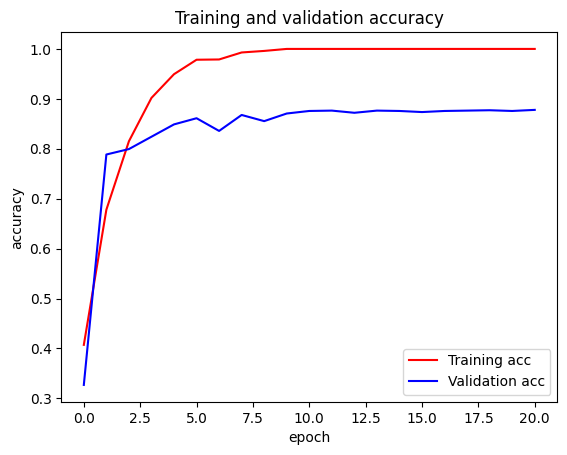

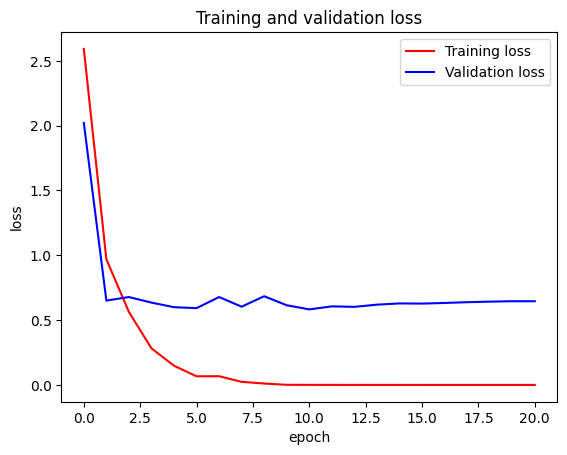

In [21]:
# Buatlah plot grafik hasil akurasi validasi training dan validasi training loss
acc = history_food_mobilenet.history['accuracy']
val_acc = history_food_mobilenet.history['val_accuracy']
loss = history_food_mobilenet.history['loss']
val_loss = history_food_mobilenet.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

[INFO] testing and evaluating...
43/43 [==============================] - 14s 313ms/step
['bakso', 'bebek_betutu', 'gado_gado', 'gudeg', 'nasi_goreng', 'pempek', 'rawon', 'rendang', 'sate', 'soto']
              precision    recall  f1-score   support

       bakso       0.84      0.79      0.82       148
bebek_betutu       0.92      1.00      0.96       142
   gado_gado       0.83      0.90      0.86       147
       gudeg       0.78      0.71      0.75       111
 nasi_goreng       0.91      0.90      0.90       145
      pempek       0.89      0.89      0.89       123
       rawon       0.85      0.88      0.87       133
     rendang       0.95      0.93      0.94       147
        sate       0.92      0.90      0.91       146
        soto       0.83      0.81      0.82       134

    accuracy                           0.88      1376
   macro avg       0.87      0.87      0.87      1376
weighted avg       0.88      0.88      0.87      1376



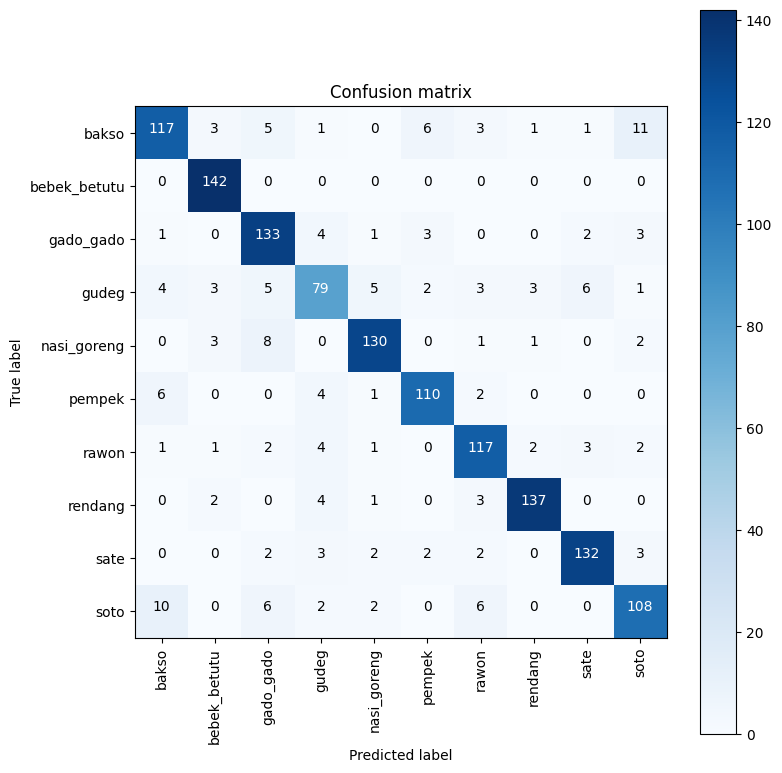

In [22]:
print("[INFO] testing and evaluating...")
# Prediksi menggunakan data validation generator
test_preds = model_food_mobilenet.predict(validation_generator_food)
# Buat hasil prediksi dalam bentuk numpy argmax
y_pred = np.argmax(test_preds, axis=1)
# Buat variabel true_classes, yang akan berisi data kelas sebenarnya dari kelas di validation generator
true_classes = validation_generator_food.classes

# Buat variabel class_labels yang akan menampilkan hasil list kelas yang ada dalam dataset
class_labels = list(validation_generator_food.class_indices.keys())
print(class_labels)

# Buat laporan hasil klasifikasi presisi, recall, dan f1
report = classification_report(true_classes, y_pred, target_names=class_labels)
print(report)

# Buat grafik confusion matrix
cm = confusion_matrix(validation_generator_food.classes, y_pred)
plot_confusion_matrix(cm, classes = class_labels)

# Konversi dari format H5 menjadi Tflite

In [23]:
import tensorflow as tf
#store .h5 file in your .py folder

#load h5 module
model=tf.keras.models.load_model('model_food.keras')
tflite_converter = tf.lite.TFLiteConverter.from_keras_model(model)

#convert
tflite_model = tflite_converter.convert()
open("MobilenetV2_model_food.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\MUHAMM~1\AppData\Local\Temp\tmp2sqfa04f\assets


INFO:tensorflow:Assets written to: C:\Users\MUHAMM~1\AppData\Local\Temp\tmp2sqfa04f\assets


92798476

# Tambahkan Metadata pada model tflite

In [24]:
from tflite_support.metadata_writers import image_classifier
from tflite_support.metadata_writers import writer_utils

In [25]:
ImageClassifierWriter = image_classifier.MetadataWriter
_MODEL_PATH = "MobilenetV2_model_food.tflite"
# Task Library expects label files that are in the same format as the one below.
_LABEL_FILE = "mobilenet_labels.txt"
_SAVE_TO_PATH = "ssd_mobilenet_v2_metadata.tflite"
# Normalization parameters is required when reprocessing the image. It is
# optional if the image pixel values are in range of [0, 255] and the input
# tensor is quantized to uint8. See the introduction for normalization and
# quantization parameters below for more details.
# https://www.tensorflow.org/lite/models/convert/metadata#normalization_and_quantization_parameters)
_INPUT_NORM_MEAN = 127.5
_INPUT_NORM_STD = 127.5

# Create the metadata writer.
writer = ImageClassifierWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), [_INPUT_NORM_MEAN], [_INPUT_NORM_STD],
    [_LABEL_FILE])

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

{
  "name": "ImageClassifier",
  "description": "Identify the most prominent object in the image from a known set of categories.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "image",
          "description": "Input image to be classified.",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  127.5
                ],
                "std": [
                  127.5
                ]
              }
            }
          ],
          "stats": {
            "max": [
              1.0
            ],
            "min": [
              -1.0
            ]
          }
        }
      ],
      "output_tensor_metadata": [
        {
          "name": "proba